# Timeseries Based LSTM Traffic Prediction Model for Router Data

# Acknowledgement

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import AdamW
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Inputs

In [2]:
path = "/Users/badeesh/Desktop/AIML/alam_dataset/jul5/fabric_stats.csv"
checkpoint_path = "/Users/badeesh/Desktop/AIML/results/model_checkpoints/"
best_checkpoint_path = "/Users/badeesh/Desktop/AIML/results/model_checkpoints/best_model_checkpoint.pth"

# Hyperparameters

In [3]:
# Define the model and other parameters
input_size = 1
hidden_size = 64
num_layers = 4
output_size = 1
num_epochs = 100
learning_rate = 0.01
dropout_prob = 0.25
patience = 100
sequence_length = 120 # Define the sequence length for input-output pairs, prediction based on 1.5 days prior data

# Read the fabric.csv file

In [4]:
sampling_time = 60
# Load the data from the CSV file
df = pd.read_csv(path)
df['time'] = pd.to_datetime(df['time'], unit='ns')
df.set_index('time', inplace=True)

In [5]:
df

,name,__device_timestamp__,_instance_id,_playbook_name,fru,in-bytes,in-rate-bps,out-bytes,out-rate-bps,tandIngestTimestamp,tandTimeOffset
time,,,,,,,,,,,
2023-06-30 17:31:53.691630413,fabric/utilization,1688146313583,"[""jun28""]",fabutil,FPCb:PIC0:NPU1:DP0,261408,3584,373440,5120,1688146313598568509,93.061904ms
2023-06-30 17:31:53.691645078,fabric/utilization,1688146313583,"[""jun28""]",fabutil,FPCb:PIC0:NPU0:DP0,261408,3584,373440,5120,1688146313598568509,93.076569ms
2023-06-30 17:31:53.691649068,fabric/utilization,1688146313583,"[""jun28""]",fabutil,FPCb:PIC0:NPU0:DP1,373440,5120,261408,3584,1688146313598568509,93.080559ms
2023-06-30 17:31:53.692609581,fabric/utilization,1688146313587,"[""jun28""]",fabutil,FPCa:PIC0:NPU2:DP1,366976,6826,256816,4778,1688146313601608460,91.001121ms
2023-06-30 17:31:53.692617094,fabric/utilization,1688146313583,"[""jun28""]",fabutil,FPCb:PIC0:NPU1:DP1,373440,5120,261408,3584,1688146313598568509,94.048585ms
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-05 22:34:49.500291554,fabric/utilization,1688596488695,"[""jun30""]",fabutil,FPC0:PIC0:NPU0:DP1,29724562159584,633772376064,19493513350928,633772834816,1688596488708899722,791.391832ms
2023-07-05 22:34:49.500295352,fabric/utilization,1688596488695,"[""jun30""]",fabutil,FPC0:PIC0:NPU1:DP1,40934382353904,633773555712,31543954886960,633774080000,1688596488708899722,791.39563ms
2023-07-05 22:34:49.500484551,fabric/utilization,1688596488695,"[""jun30""]",fabutil,FPC0:PIC0:NPU3:DP0,58291009556064,633775587328,20449684562768,633776111616,1688596488708899722,791.584829ms


# Data Pre-Processing & Data Cleaning 

In [6]:
# Data Cleaning

pfe_spec = 'FPC0:PIC0:NPU0:DP0'
rate_bps_lower_limit = 0
rate_bps_upper_limit = 2e12


# Step 1: Drop First 1000 elements
df = df[1000:]

# Filter for one FPC: FPC0:PIC0:NPU0:DP0
df_per_fpc_per_pfe = df[df['fru']== pfe_spec]

# Filter for in-rate-bps >0 and out-rate-bps >0

df_filtered = df_per_fpc_per_pfe[(df_per_fpc_per_pfe['out-rate-bps'] > rate_bps_lower_limit) & (df_per_fpc_per_pfe['out-rate-bps'] < rate_bps_upper_limit)]

df_filtered = df_filtered[3200:]

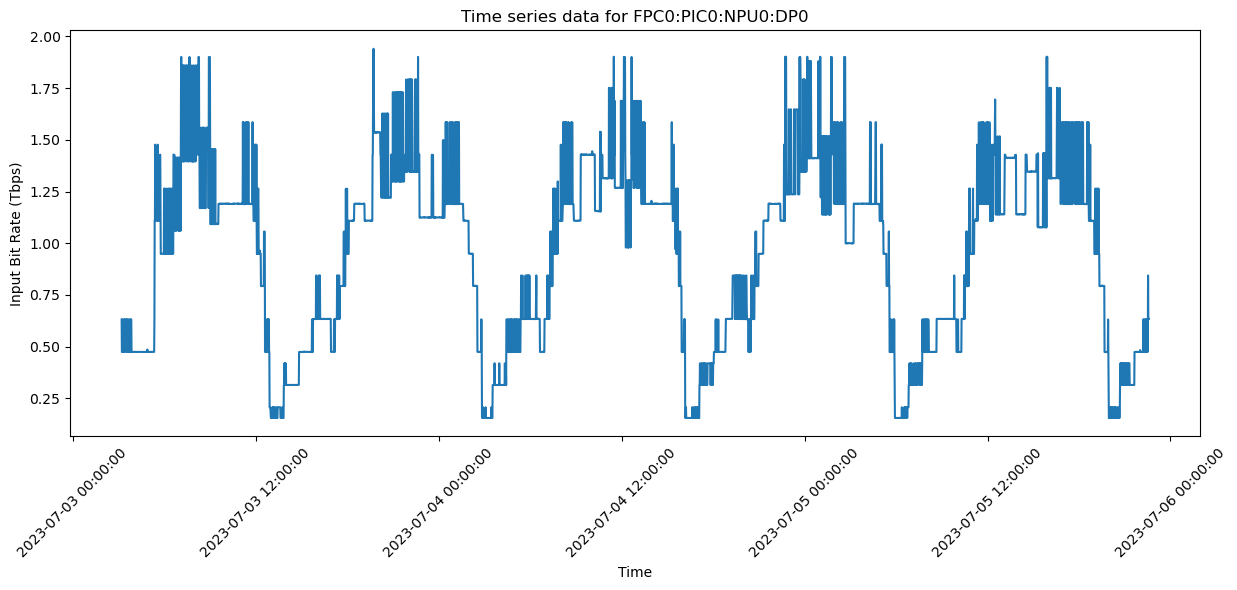

In [7]:
# Plot the original data
plt.figure(figsize=(24,6))
plt.subplot(1, 2, 1)
plt.plot(df_filtered.index, df_filtered['out-rate-bps']/1e12)
plt.title(f'Time series data for {pfe_spec}')
plt.xlabel('Time')
plt.ylabel('Input Bit Rate (Tbps)')
# plt.yticks(tick_locations, tick_labels)

# Format x-axis as date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

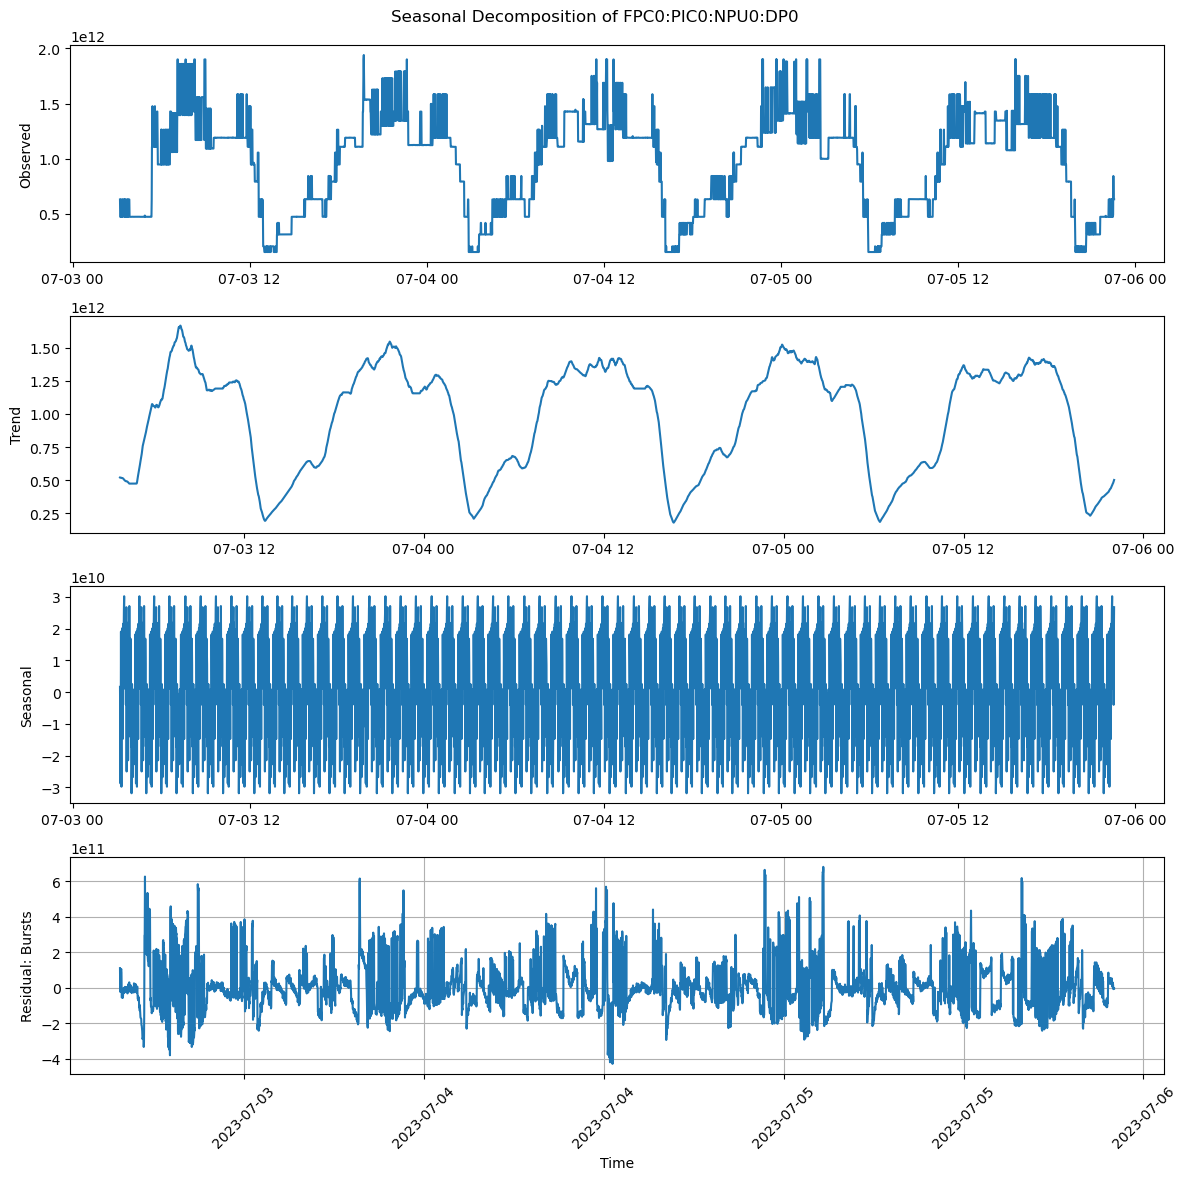

In [8]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df_filtered['out-rate-bps'], model='additive', period=60)

# Plot seasonal decomposition
plt.figure(figsize=(12,12))
plt.subplot(411)
plt.plot(df_filtered.index, decomposition.observed)
plt.ylabel('Observed')

plt.subplot(412)
plt.plot(df_filtered.index, decomposition.trend)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(df_filtered.index, decomposition.seasonal)
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(df_filtered.index, decomposition.resid)
plt.ylabel('Residual: Bursts')

plt.xlabel('Time')
plt.suptitle(f'Seasonal Decomposition of {pfe_spec}')
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Building ML Model

Epoch 1/100, Training Loss: 0.353821, Validation Loss: 0.066123
Epoch 2/100, Training Loss: 0.116550, Validation Loss: 2.291008
Epoch 3/100, Training Loss: 1.924981, Validation Loss: 0.070413
Epoch 4/100, Training Loss: 0.059387, Validation Loss: 0.068108
Epoch 5/100, Training Loss: 0.119841, Validation Loss: 0.088557
Epoch 6/100, Training Loss: 0.154185, Validation Loss: 0.092430
Epoch 7/100, Training Loss: 0.160049, Validation Loss: 0.087374
Epoch 8/100, Training Loss: 0.152173, Validation Loss: 0.077518
Epoch 9/100, Training Loss: 0.136018, Validation Loss: 0.065510
Epoch 10/100, Training Loss: 0.114794, Validation Loss: 0.054432
Epoch 11/100, Training Loss: 0.090796, Validation Loss: 0.050253
Epoch 12/100, Training Loss: 0.068449, Validation Loss: 0.065682
Epoch 13/100, Training Loss: 0.059436, Validation Loss: 0.100979
Epoch 14/100, Training Loss: 0.072381, Validation Loss: 0.100899
Epoch 15/100, Training Loss: 0.072629, Validation Loss: 0.083612
Epoch 16/100, Training Loss: 0.064

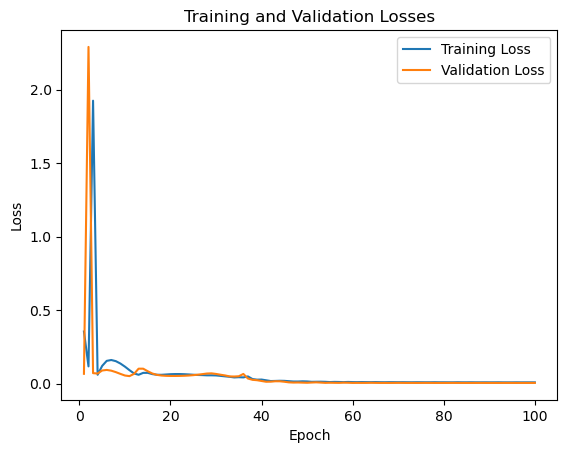

Training time: 349.53 seconds


In [9]:
import copy

# Prepare the data
amplitude_data = (df_filtered['out-rate-bps']).values.reshape(-1, 1)  # Reshape the amplitude data
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale the data between 0 and 1
scaled_data = scaler.fit_transform(amplitude_data)  # Apply scaling

# Convert the scaled data into input-output pairs
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length+1]
        sequences.append(sequence)
    return np.array(sequences)  # Convert list to NumPy ndarray

sequences = create_sequences(scaled_data, sequence_length)
sequences = torch.FloatTensor(sequences)  # Convert NumPy ndarray to PyTorch tensor

# Split the data into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(sequences))
val_size = int(val_ratio * len(sequences))
test_size = len(sequences) - train_size - val_size

train_data = sequences[:train_size]
val_data = sequences[train_size:train_size + val_size]
test_data = sequences[train_size + val_size:]
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout= self.dropout_prob)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        #out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

def train_model(model, criterion, optimizer, train_data, val_data, num_epochs, patience):
        best_loss = float('inf')
        best_model = None
        no_improvement = 0

        losses_train = []  # List to store training losses
        losses_val = []  # List to store validation losses

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(train_data[:, :-1])
            loss = criterion(outputs, train_data[:, -1])
            loss.backward()
            optimizer.step()

            model.eval()
            val_outputs = model(val_data[:, :-1])
            val_loss = criterion(val_outputs, val_data[:, -1])

            if val_loss < best_loss:
                best_loss = val_loss
                best_model = copy.deepcopy(model)
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            if (epoch+1) % 1 == 0:
                losses_train.append(loss.item())
                losses_val.append(val_loss.item())
                print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.6f}, Validation Loss: {val_loss.item():.6f}")
                # Save the best model checkpoint
                checkpoint_path_epoch = checkpoint_path + "best_model_checkpoint"+ str(epoch+1) + ".pth"
                torch.save(model.state_dict(), checkpoint_path_epoch)
        
        #Plot the training and validation losses
        plt.plot(range(1, num_epochs + 1), losses_train, label='Training Loss')
        plt.plot(range(1, num_epochs + 1), losses_val, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()
        
        return best_model

model = LSTM(input_size, hidden_size, num_layers, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Convert the data to tensors
train_data = torch.FloatTensor(train_data)
val_data = torch.FloatTensor(val_data)

# Train the model with early stopping
start_time = time.time()
best_model = train_model(model, criterion, optimizer, train_data, val_data, num_epochs, patience)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Save the best model checkpoint
torch.save(best_model.state_dict(), best_checkpoint_path)

# Model Evaluation 

In [10]:
# Load checkpoint
# checkpoint_path =  "/Users/badeesh/Desktop/AIML/results/model_checkpoints/best_model_checkpoint"+ str(158) + ".pth"
# best_model = LSTM(input_size, hidden_size, num_layers, output_size, dropout_prob)
# best_model.load_state_dict(torch.load(checkpoint_path))

Evaluation Metrics:
Mean Absolute Error (MAE): 0.098279
Root Mean Squared Error (RMSE): 0.149791


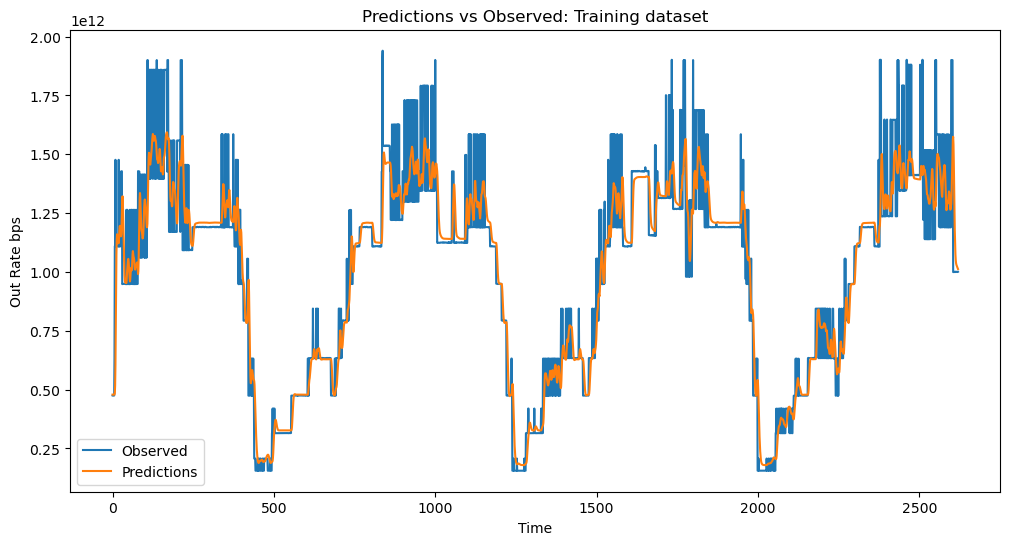

In [11]:
# Evaluate on the Train dataset
best_model.eval()
predictions = []
observations = []

with torch.no_grad():
    for i in range(len(train_data)):
        sequence = train_data[i]
        inputs = sequence[:-1]
        target = sequence[-1]

        inputs = inputs.unsqueeze(0)
        output = best_model(inputs)
        prediction = scaler.inverse_transform(output).item()

        predictions.append(prediction)
        observations.append(target.item())

# Convert predictions and observations to NumPy arrays
predictions = np.array(predictions)
observations = np.array(observations)

unscaled_observations = scaler.inverse_transform(observations.reshape(-1, 1))/1e12
unscaled_predictions = predictions / 1e12

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(unscaled_observations, unscaled_predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(unscaled_observations, unscaled_predictions, squared=False)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((unscaled_observations - unscaled_predictions) / unscaled_observations)) * 100

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
#print(f"Mean Absolute Percentage Error (MAPE): {mape:.6f}%")

import matplotlib.pyplot as plt

# Plot predictions and observed values
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(observations.reshape(-1, 1)), label='Observed')  # Unscale the observations
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Out Rate bps')
plt.title('Predictions vs Observed: Training dataset')
plt.legend()
plt.show()

In [12]:
print(len(predictions))
print(len(observations))

2621
2621


# Anamoly Detection

## Burst Anamoly Detection

## Sliding Window Anamoly Detection 

## Anamoly Visuation on Train dataset 

In [13]:
# Manipulate dataset to induce anamolies to be detected
observations_anamolous = observations.copy()
observations_anamolous[500:1250] = observations_anamolous[500:1250]*0.65

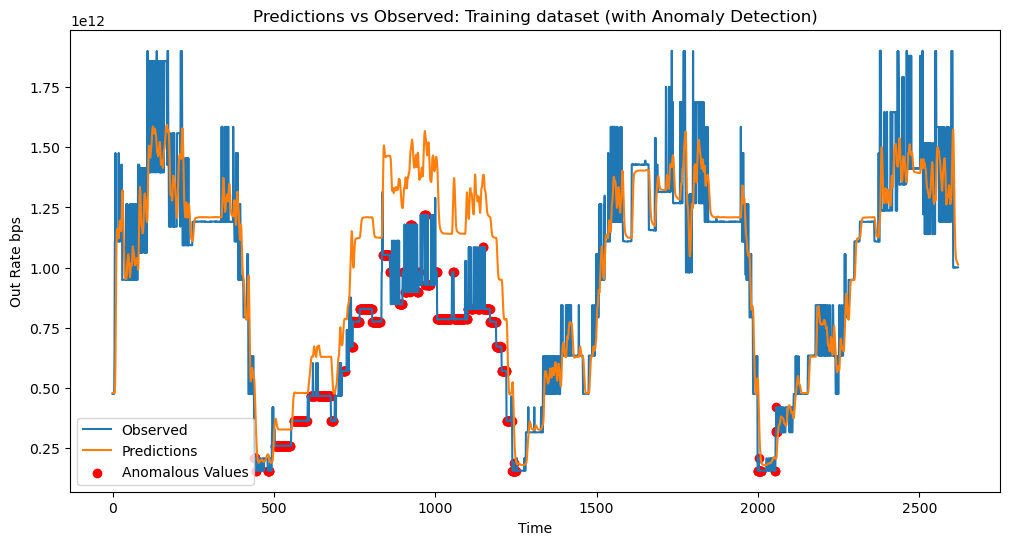

In [14]:
import matplotlib.pyplot as plt

# Define the threshold for anomaly detection (25% difference)
threshold = 0.25


# Define the number of continuous anomalous samples required to flag an anomaly
N = 6

# Initialize variables
anomaly_count = 0
anomalous_indices = []

# Iterate over the predicted values and observed values
for i in range(len(predictions)):
    # Calculate the percentage difference between predicted and observed values
    percentage_difference = abs(predictions[i] - scaler.inverse_transform(observations_anamolous[i:i+1].reshape(1, -1))) / scaler.inverse_transform(observations_anamolous[i:i+1].reshape(1, -1))
    abs_difference = abs(predictions[i] - scaler.inverse_transform(observations_anamolous[i:i+1].reshape(1, -1)))
    
    # Check if the percentage difference exceeds the threshold
    if percentage_difference > threshold: #and abs_difference > abs_threshold:
        anomaly_count += 1
    else:
        # Reset the anomaly count if the current sample is not anomalous
        anomaly_count = 0
    
    # Check if the required number of continuous anomalous samples is reached
    if anomaly_count >= N:
        # Flag the anomalous samples by adding their indices to the list
        anomalous_indices.extend(range(i - anomaly_count + 1, i + 1))
        anomaly_count = 0  # Reset the anomaly count

# Plot the predicted values, observed values, and anomalous values
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(observations_anamolous.reshape(-1, 1)), label='Observed')  # Unscale the observations
plt.plot(predictions, label='Predictions')

if len(anomalous_indices) > 0:
    plt.scatter(anomalous_indices, scaler.inverse_transform(observations_anamolous[anomalous_indices].reshape(-1, 1)), color='red', label='Anomalous Values')

plt.xlabel('Time')
plt.ylabel('Out Rate bps')
plt.title('Predictions vs Observed: Training dataset (with Anomaly Detection)')
plt.legend()
plt.show()

## Sliding Window on Train Dataset

In [15]:
observations_anamolous_slide = observations.copy()
observations_anamolous_slide[500:1250] = observations_anamolous_slide[500:1250] * 0.850

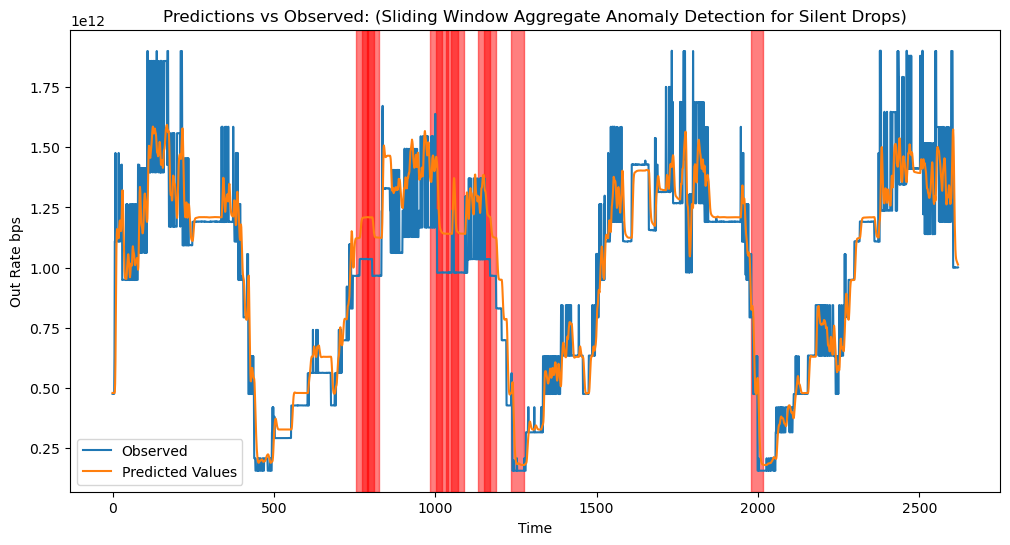

In [16]:
import matplotlib.pyplot as plt

# Define the threshold for anomaly detection (15% difference)
threshold = 0.15

# Define the sliding window size and number of anomalous samples threshold
window_size = 40
value = 30
anomalous_samples_threshold = value
# Initialize variables
anomaly_windows = []

# Iterate over the predicted values and observed values
for i in range(len(predictions)):
    # Calculate the percentage difference between predicted and observed values
    percentage_difference = abs(predictions[i] - scaler.inverse_transform(observations_anamolous_slide[i:i+1].reshape(1, -1))) / scaler.inverse_transform(observations_anamolous_slide[i:i+1].reshape(1, -1))
    abs_difference = abs(predictions[i] - scaler.inverse_transform(observations_anamolous_slide[i:i+1].reshape(1, -1)))
    # Check if the percentage difference exceeds the threshold
    if percentage_difference > threshold and abs_difference>= 0.35:
        # Flag the current sample as anomalous
        anomalous_samples_threshold -= 1
    else:
        # Reset the anomalous samples count if the current sample is not anomalous
        anomalous_samples_threshold = value
    
    # Check if the number of anomalous samples in the window exceeds the threshold
    if anomalous_samples_threshold <= 0:
        # Flag the window as anomalous
        window_start = i - window_size + 1
        anomaly_windows.append(window_start)
        
        # Reset the anomalous samples count
        anomalous_samples_threshold = value
    
    # Check if the sliding window has reached its size
    if i >= window_size:
        # Remove the oldest sample from the window count
        if abs(predictions[i - window_size] - scaler.inverse_transform(observations_anamolous_slide[i - window_size:i - window_size + 1].reshape(1, -1))) / scaler.inverse_transform(observations_anamolous_slide[i - window_size:i - window_size + 1].reshape(1, -1)) > threshold:
            anomalous_samples_threshold -= 1
        
        # Check if the window is already flagged as anomalous
        window_start = i - window_size + 1
        if window_start in anomaly_windows:
            # Reset the anomalous samples count
            anomalous_samples_threshold = value
    
# Plot the predicted values, observed values, and anomalous values
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(observations_anamolous_slide.reshape(-1, 1)), label='Observed')  # Unscale the observations
plt.plot(predictions, label='Predicted Values')

if len(anomaly_windows) > 0:
    # Highlight the anomalous windows
    for window_start in anomaly_windows:
        plt.axvspan(window_start, window_start + window_size - 1, color='red', alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Out Rate bps')
plt.title('Predictions vs Observed: (Sliding Window Aggregate Anomaly Detection for Silent Drops)')
plt.legend()
plt.show()